References: "[How to wrap a JAX function for use in PyMC](https://www.pymc.io/projects/examples/en/latest/case_studies/wrapping_jax_function.html)" and [this page](https://notebooks.githubusercontent.com/view/ipynb?color_mode=auto&commit=f6883db111b56c6d7216466b7b455a9b8229520c&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f676973742f74776965636b692f62616466323362373866643132333764313666346331393039646462653365332f7261772f663638383364623131316235366336643732313634363662376234353561396238323239353230632f50794d4333253230767325323050794d43253230342e302e6970796e62&logged_in=false&nwo=twiecki%2Fbadf23b78fd1237d16f4c1909ddbe3e3&path=PyMC3+vs+PyMC+4.0.ipynb&repository_id=113837376&repository_type=Gist).


In [1]:
import numpy as np

In [2]:
import pymc
pymc.__version__

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


'4.1.5'

この例では、phaseとノイズレベルsigmaを推定します。観測値はy=sin(x + phase)です。

In [3]:
np.random.seed(32)
phase=0.5
sigin=0.3
N=20
x=np.sort(np.random.rand(N))*4*np.pi
y=np.sin(x+phase)+np.random.normal(0,sigin,size=N)

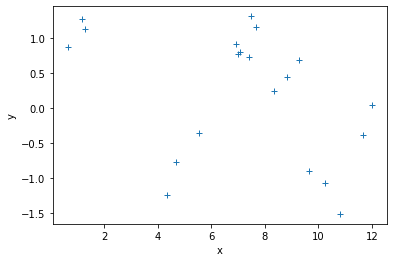

In [4]:
import matplotlib.pyplot as plt
plt.plot(x,y,"+",color="C0")
plt.xlabel("x")
plt.ylabel("y")
plt.savefig("hmc1.png")

In [5]:
import aesara.tensor as at
from aesara.graph import Apply, Op
import jax.numpy as jnp
import jax
from jax import config

#float64nise
config.update("jax_enable_x64", True)
x = np.array(x,dtype=np.float64)
y = np.array(y,dtype=np.float64)
phase = np.float64(phase)

def sinmodel(x,phase):
    return jnp.sin(x + phase)

grad_sinmodel = jax.jit(jax.vmap(jax.grad(sinmodel, argnums=(1)),in_axes=(0,None)))
#grad_sinmodel = jax.jit(jax.grad(jax.vmap(sinmodel,(None,),0),argnums=(0,)))

In [6]:
sinmodel(x,phase)

DeviceArray([ 0.90333137,  0.9965908 ,  0.98016681, -0.99215406,
             -0.89100715, -0.23036223,  0.91154038,  0.92939441,
              0.95700625,  0.99861417,  0.98985979,  0.95524485,
              0.56165448,  0.08157524, -0.32639316, -0.64846527,
             -0.97161353, -0.95605865, -0.38817033, -0.05720499],            dtype=float64)

In [7]:
grad_sinmodel(x,phase)

DeviceArray([ 0.42894339, -0.08250324, -0.19817423,  0.12502128,
              0.45398928,  0.97310495,  0.41121058,  0.36908812,
              0.2900673 , -0.05262835, -0.14204785, -0.29581628,
             -0.82737189, -0.99666719, -0.9452341 , -0.76124424,
             -0.23657378,  0.29317546,  0.92158765,  0.99836245],            dtype=float64)

In [8]:
import aesara 
class HMCGradOp(Op):
    def make_node(self, x, phase):
        inputs = [at.as_tensor_variable(x), at.as_tensor_variable(phase)]
        #outputs = [inp.type() for inp in inputs]
        outputs = [at.dvector()] 
        #the data structure as checked the previous cell
        #print("=>",outputs)
        return Apply(self, inputs, outputs)

    def perform(self, node, inputs, outputs):
        #(grad_x, grad_phase) = grad_sinmodel(*inputs)
        grad_phase = grad_sinmodel(*inputs)
        #outputs[0][0] = np.asarray(grad_x, dtype=node.outputs[0].dtype)
        outputs[0][0] = np.asarray(grad_phase, dtype=node.outputs[0].dtype)
        #outputs[1][0] = np.asarray(grad_phase, dtype=node.outputs[1].dtype)
        
hmc_grad_op = HMCGradOp()

#check
hmc_grad_op(x,phase).eval()


array([ 0.42894339, -0.08250324, -0.19817423,  0.12502128,  0.45398928,
        0.97310495,  0.41121058,  0.36908812,  0.2900673 , -0.05262835,
       -0.14204785, -0.29581628, -0.82737189, -0.99666719, -0.9452341 ,
       -0.76124424, -0.23657378,  0.29317546,  0.92158765,  0.99836245])

In [15]:
import aesara
class HMCOp(Op):
    def make_node(self, x, phase):
        inputs = [at.as_tensor_variable(x), at.as_tensor_variable(phase)]
        #outputs = [at.dscalar()]
        outputs = [at.dvector()]
        #YES, in our case, outputs is float64 vector 
        #as shown by the output of sinmodel(x,phase).
        #https://aesara.readthedocs.io/en/latest/library/tensor/basic.html#all-fully-typed-constructors
        return Apply(self, inputs, outputs)

    def perform(self, node, inputs, outputs):
        result = sinmodel(*inputs)
        #outputs[0][0] = np.asarray(result, dtype=node.outputs[0].dtype)
        outputs[0][0] = np.asarray(result, dtype=node.outputs[0].dtype)
        

    def grad(self, inputs, output_gradients):
        #(grad_x, grad_phase) = hmc_grad_op(*inputs)
        grad_phase = hmc_grad_op(*inputs)
        #output_gradient = output_gradients[0]
        #return [output_gradient * grad_x, output_gradient * grad_phase]
        output_gradient = output_gradients[0]
        #print(output_gradients)
        #output_gradient = output_gradients
        #return output_gradient * grad_phase
        #return  [aesara.gradient.grad_not_implemented(op=self,x_pos=0,x=inputs[0]), aesara.gradient.grad_not_implemented(op=self,x_pos=1,x=inputs[1])] #passed 
        #return  [aesara.gradient.grad_not_implemented(op=self,x_pos=0,x=inputs[0]), output_gradient[1] * at.sum(grad_phase)] #passed, dimension matched
        #return  [aesara.gradient.grad_not_implemented(op=self,x_pos=0,x=inputs[0]) , output_gradient[1] * at.sum(grad_phase)] #passed, dimension matched
        #return [aesara.gradient.grad_not_implemented(op=self,x_pos=0,x=inputs[0]), output_gradient * grad_phase]
        #return [aesara.gradient.grad_not_implemented(op=self,x_pos=0,x=inputs[0]) * output_gradients[0], output_gradients[1] * grad_phase]
        return [output_gradient * grad_phase, output_gradient * grad_phase]
#check
hmc_op = HMCOp()
hmc_op(x,phase).eval()



array([ 0.90333137,  0.9965908 ,  0.98016681, -0.99215406, -0.89100715,
       -0.23036223,  0.91154038,  0.92939441,  0.95700625,  0.99861417,
        0.98985979,  0.95524485,  0.56165448,  0.08157524, -0.32639316,
       -0.64846527, -0.97161353, -0.95605865, -0.38817033, -0.05720499])

In [16]:
#See https://docs.exoplanet.codes/en/latest/tutorials/autodiff/
# cite:
# Request the gradient of y with respect to x
# Note the call to `sum`. This is a bit of a cheat since by
# default Aesara only computes gradients of a *scalar* function

at_phase = at.as_tensor_variable(phase)
yt = hmc_op(x,at_phase)

#def f(x,phase):
#    return at.sin(x+phase)
#yt=f(x,at_phase)

yt_grad = at.grad(at.max(yt),wrt=at_phase)
#https://aesara.readthedocs.io/en/latest/library/tensor/basic.html#gradient-differentiation
yt_grad.eval()

ValueError: HMCOp.grad returned a term with 1 dimensions, but 0 are required.

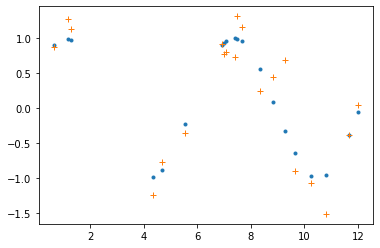

In [159]:
import matplotlib.pyplot as plt

plt.plot(x, hmc_op(x, phase).eval(),".")
plt.plot(x, y,"+")


In [81]:
import jax.numpy as jnp
import pymc

def build_model(x,y):
    with pymc.Model() as pmmodel:
        phase = pymc.Uniform('phase', lower = -1.0*jnp.pi, upper = 1.0*jnp.pi)
        sigma = pymc.Exponential('sigma', lam = 1.)
        mu=hmc_op(x,phase)
        #mu = at.sin(x+phase) #this works
        d=pymc.Normal('y', mu = mu, sigma = sigma, observed=y)
    return pmmodel


In [82]:
model_pymc = build_model(x,y)
with model_pymc:
    idata = pymc.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [phase, sigma]
INFO:pymc:NUTS: [phase, sigma]
2022-09-01 17:49:16.389446: F external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:153] Failed setting context: CUDA_ERROR_NOT_INITIALIZED: initialization error
2022-09-01 17:49:16.389430: F external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:153] Failed setting context: CUDA_ERROR_NOT_INITIALIZED: initialization error
2022-09-01 17:49:16.389430: F external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:153] Failed setting context: CUDA_ERROR_NOT_INITIALIZED: initialization error


2022-09-01 17:49:16.391144: F external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:153] Failed setting context: CUDA_ERROR_NOT_INITIALIZED: initialization error


ConnectionResetError: [Errno 104] Connection reset by peer

array([[<AxesSubplot:title={'center':'phase'}>,
        <AxesSubplot:title={'center':'phase'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

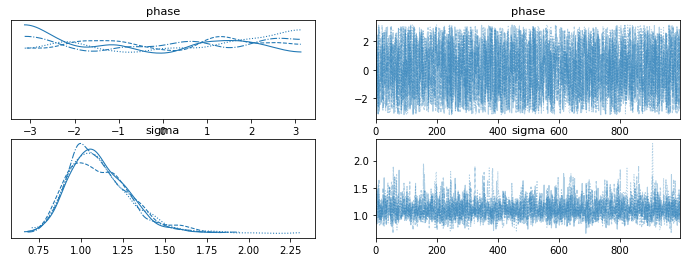

In [162]:
import arviz 
arviz.plot_trace(idata)